# Linear regresssion

In [39]:
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.datasets import fetch_california_housing, fetch_openml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


## Load data

In [21]:
housing_data, housing_target = fetch_california_housing(return_X_y=True, as_frame=True)
print(housing_data.info())
housing_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB
None
<class 'pandas.core.series.Series'>
RangeIndex: 20640 entries, 0 to 20639
Series name: MedHouseVal
Non-Null Count  Dtype  
--------------  -----  
20640 non-null  float64
dtypes: float64(1)
memory usage: 161.4 KB


## visualize data

In [22]:
housing_data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [23]:
housing_target.head()

0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: MedHouseVal, dtype: float64

array([[<Axes: title={'center': 'MedInc'}>,
        <Axes: title={'center': 'HouseAge'}>,
        <Axes: title={'center': 'AveRooms'}>],
       [<Axes: title={'center': 'AveBedrms'}>,
        <Axes: title={'center': 'Population'}>,
        <Axes: title={'center': 'AveOccup'}>],
       [<Axes: title={'center': 'Latitude'}>,
        <Axes: title={'center': 'Longitude'}>, <Axes: >]], dtype=object)

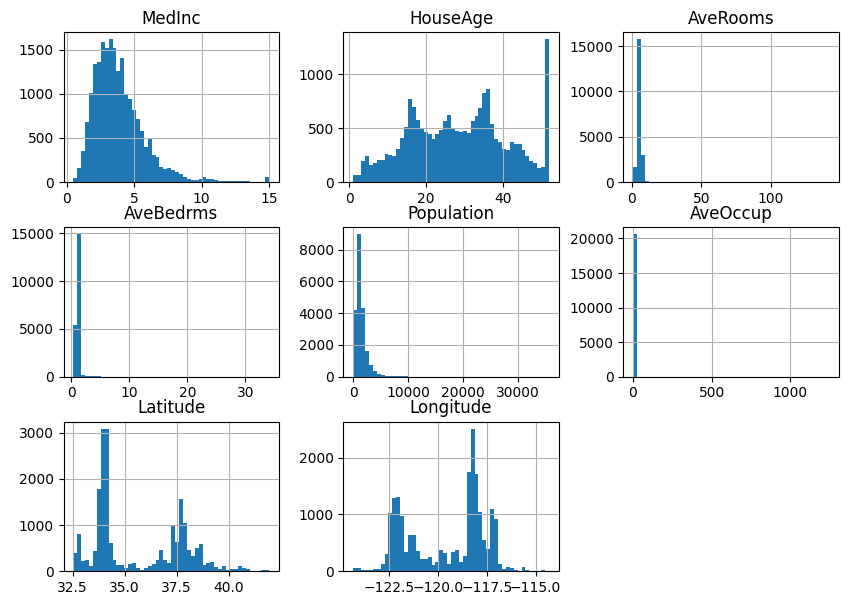

In [24]:
housing_data.hist(bins=50, figsize=(10, 7))

#### Splitting the data

In [25]:
X_train, X_test, y_train, y_test = train_test_split(housing_data, housing_target, test_size=0.15, random_state=42)

In [26]:
print(X_train.shape)
X_test.shape

(17544, 8)


(3096, 8)

In [27]:
class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state
    def fit(self, X, y=None, sample_weight = None):
        self.kmeans_ = KMeans(self.n_clusters, random_state = self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self
    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

### Build pipe lines

In [28]:
#housing_data["Population"] = np.log(housing_data["Population"].to_numpy())
#housing_data["MedInc"] = housing_data["MedInc"].apply(np.log).hist(bins=50)
#housing_data["AveBedrms"] = np.log(housing_data["AveBedrms"].to_numpy())
#housing_data["Population"].hist(bins=50)
#housing_data["MedInc"].hist(bins=50)
default_pipe = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
log_pipe = make_pipeline(SimpleImputer(strategy="median"), FunctionTransformer(np.log),StandardScaler())
cluster_similarity = ClusterSimilarity(n_clusters=10, gamma=1.0, random_state=42)

In [29]:
preprocessing = ColumnTransformer([("log", log_pipe, ["MedInc", "AveBedrms", "Population"]),
                                  ("geo", cluster_similarity, ["Latitude", "Longitude"]),], remainder=default_pipe)
# cluster similarity extracts 10 features

In [30]:
X_train_prep = preprocessing.fit_transform(X_train)
X_test_prep = preprocessing.fit_transform(X_test)

In [31]:
def rmse(input, target):
    return np.sqrt(np.mean((input-target)**2))

In [32]:
x = np.array([2, 2, 2, 2])
y = np.array([2, 4, 2, 2])
rmse(x, y)

1.0

## Linear regression

In [52]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_prep, y_train)
y_train_preds = lin_reg.predict(X_train_prep) # training predictions
y_test_preds = lin_reg.predict(X_test_prep) #test predictions

print(f"training error (rmse): {rmse(y_train, y_train_preds)}")
print(f"test error (rmse): {rmse(y_test, y_test_preds)}")

training error (rmse): 0.7683848991243523
test error (rmse): 1.1484137729089958


## SGD regression

In [49]:
sgd_reg = SGDRegressor(random_state=42)
sgd_reg.fit(X_train_prep, y_train)
y_train_preds = sgd_reg.predict(X_train_prep) # training predictions
y_test_preds = sgd_reg.predict(X_test_prep) #test predictions

print(f"training error (rmse): {rmse(y_train, y_train_preds)}")
print(f"test error (rmse): {rmse(y_test, y_test_preds)}")

training error (rmse): 1.6853653335733907
test error (rmse): 1.7479992448841108


## Random Forest regression

In [50]:
rf_reg = SGDRegressor(random_state=42)
rf_reg.fit(X_train_prep, y_train)
y_train_preds = rf_reg.predict(X_train_prep) # training predictions
y_test_preds = rf_reg.predict(X_test_prep) #test predictions

print(f"training error (rmse): {rmse(y_train, y_train_preds)}")
print(f"test error (rmse): {rmse(y_test, y_test_preds)}")

training error (rmse): 1.6853653335733907
test error (rmse): 1.7479992448841108
